In [1]:
import calendar 
import datetime
import dask.dataframe as dd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import SVG, display

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')
#plt.style.available

In [3]:
%%time
# set data file path
parquet_data_folder = '../data/crimes-2017.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2017.snappy.parq
Crime data loaded into memory.
Wall time: 2.05 s


In [4]:
%%time
# log records count and data partitions
print('Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Crime data stats:
---------------------------------------
159,919 total records in 1 partitions
DataFrame size: 1,599,190
Wall time: 5.51 ms


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude,Year
npartitions=1,,,,,,,,,,
2017-01-01 00:00:00,object,category[unknown],category[unknown],category[unknown],category[unknown],bool,bool,float64,float64,category[unknown]
2017-08-10 23:55:00,...,...,...,...,...,...,...,...,...,...


In [6]:
# preview crimes data with Date index
crimes.head()

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude,Year
Date,,,,,,,,,,
2017-01-01,087XX S SAGINAW AVE,OFFENSE INVOLVING CHILDREN,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,46.0,False,True,NaN,NaN,2017
2017-01-01,003XX N ELIZABETH ST,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,OTHER,28.0,False,False,NaN,NaN,2017
2017-01-01,058XX S SANGAMON ST,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,68.0,False,False,NaN,NaN,2017
2017-01-01,035XX S GILES AVE,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,"SCHOOL, PUBLIC, BUILDING",35.0,False,False,NaN,NaN,2017
2017-01-01,052XX S KENWOOD AVE,THEFT,OVER $500,VEHICLE NON-COMMERCIAL,41.0,False,False,41.800292,-87.593087,2017


In [7]:
# get crime types and counts by primary type
crime_types = crimes[['PrimaryType']]
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# print crime stats
print(crime_type_total.sort_values(ascending=False))
print("...\nTotal Primary Crime Types: {:,}".format(crime_type_total.size))

PrimaryType
THEFT                                37563
BATTERY                              30170
CRIMINAL DAMAGE                      17806
ASSAULT                              11855
OTHER OFFENSE                        10923
DECEPTIVE PRACTICE                   10318
BURGLARY                              7804
MOTOR VEHICLE THEFT                   6848
ROBBERY                               6750
NARCOTICS                             6501
CRIMINAL TRESPASS                     4247
WEAPONS VIOLATION                     2843
OFFENSE INVOLVING CHILDREN            1277
PUBLIC PEACE VIOLATION                 945
CRIM SEXUAL ASSAULT                    907
INTERFERENCE WITH PUBLIC OFFICER       679
SEX OFFENSE                            556
PROSTITUTION                           541
HOMICIDE                               414
ARSON                                  279
LIQUOR LAW VIOLATION                   133
STALKING                               128
GAMBLING                               115

In [8]:
# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']]\
.groupby('PrimaryType').sum().compute()

# print arrests stats
print(crime_type_counts.sort_values(by='Arrest', ascending=False))

                                   Arrest  Domestic
PrimaryType                                        
NARCOTICS                          6488.0       5.0
BATTERY                            5999.0   14716.0
THEFT                              3753.0    1430.0
CRIMINAL TRESPASS                  2560.0     206.0
OTHER OFFENSE                      2450.0    3377.0
WEAPONS VIOLATION                  2272.0      11.0
ASSAULT                            2109.0    3054.0
CRIMINAL DAMAGE                    1053.0    2068.0
INTERFERENCE WITH PUBLIC OFFICER    642.0       3.0
PUBLIC PEACE VIOLATION              635.0      32.0
MOTOR VEHICLE THEFT                 547.0      67.0
PROSTITUTION                        541.0       0.0
ROBBERY                             414.0     127.0
DECEPTIVE PRACTICE                  386.0      95.0
BURGLARY                            275.0     106.0
OFFENSE INVOLVING CHILDREN          152.0     636.0
LIQUOR LAW VIOLATION                133.0       1.0
GAMBLING    

In [9]:
# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic + total)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic  Total
PrimaryType                                               
THEFT                              3753.0    1430.0  37563
BATTERY                            5999.0   14716.0  30170
CRIMINAL DAMAGE                    1053.0    2068.0  17806
ASSAULT                            2109.0    3054.0  11855
OTHER OFFENSE                      2450.0    3377.0  10923
DECEPTIVE PRACTICE                  386.0      95.0  10318
BURGLARY                            275.0     106.0   7804
MOTOR VEHICLE THEFT                 547.0      67.0   6848
ROBBERY                             414.0     127.0   6750
NARCOTICS                          6488.0       5.0   6501
CRIMINAL TRESPASS                  2560.0     206.0   4247
WEAPONS VIOLATION                  2272.0      11.0   2843
OFFENSE INVOLVING CHILDREN          152.0     636.0   1277
PUBLIC PEACE VIOLATION              635.0      32.0    945
CRIM SEXUAL ASSAULT                  34.0     124.0    9

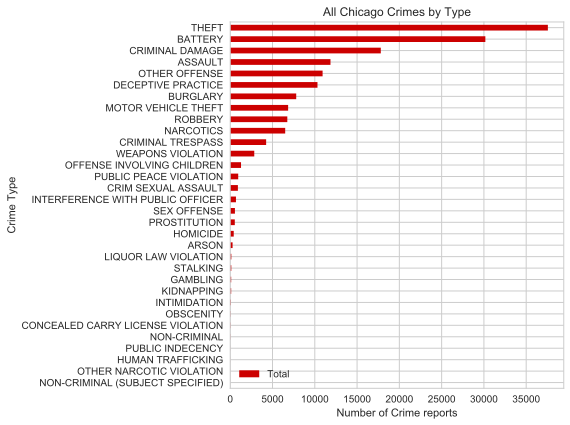

In [10]:
# plot crimes by primary type counts
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True)\
.drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(8,6), color='#cc0000')
plt.title('All Chicago Crimes by Type')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

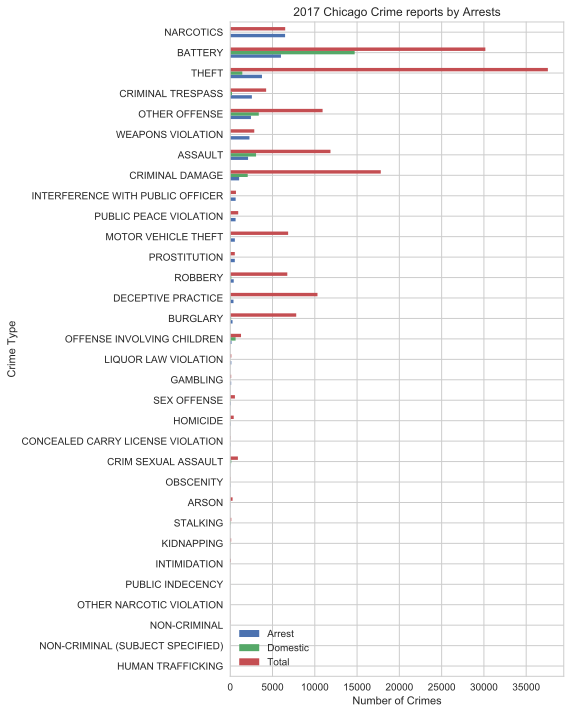

In [11]:
# plot crimes by arrests
crime_type_counts.sort_values(by='Arrest', ascending=True)\
.plot(kind='barh', figsize=(8,10))
plt.title('2017 Chicago Crime reports by Arrests')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

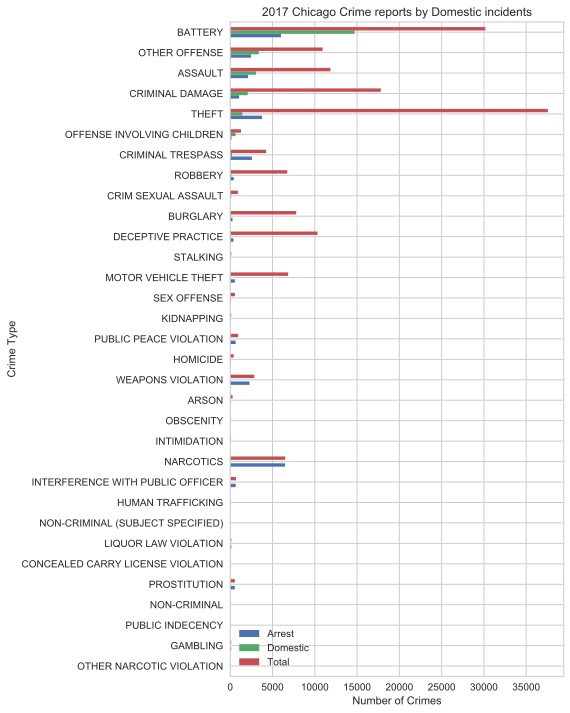

In [12]:
# plot crimes by domestic incident reports
crime_type_counts.sort_values(by='Domestic', ascending=True)\
.plot(kind='barh', figsize=(8,10))
plt.title('2017 Chicago Crime reports by Domestic incidents')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

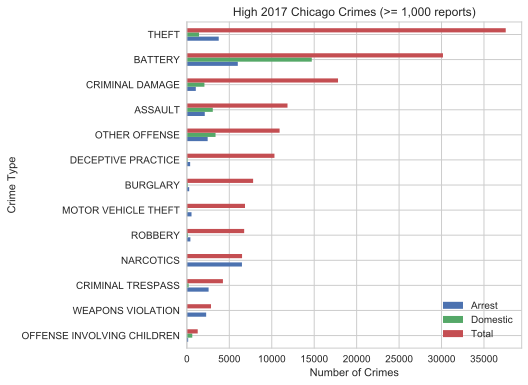

In [13]:
# plot high crimes (>-= 1,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 1000]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('High 2017 Chicago Crimes (>= 1,000 reports)')
plt.show()

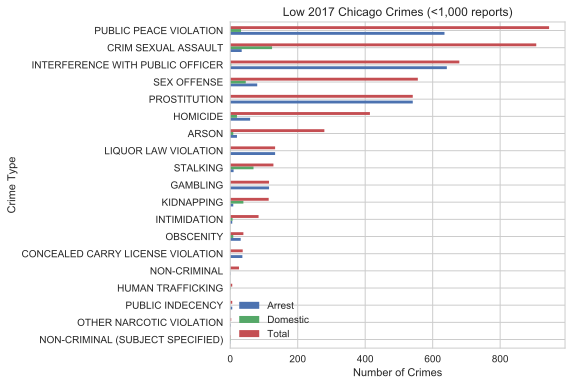

In [14]:
# plot less than 1000 crime reports types
crime_type_counts[crime_type_counts['Total'] < 1000]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Low 2017 Chicago Crimes (<1,000 reports)')
plt.show()

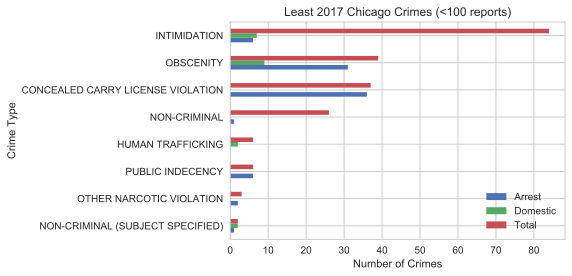

In [15]:
# plot less than 100 crime reports types
crime_type_counts[crime_type_counts['Total'] < 100]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Least 2017 Chicago Crimes (<100 reports)')
plt.show()

In [16]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       36104
RESIDENCE    27299
APARTMENT    20173
SIDEWALK     12643
OTHER         6622
Name: Total, dtype: int64
...
Total Locations: 121


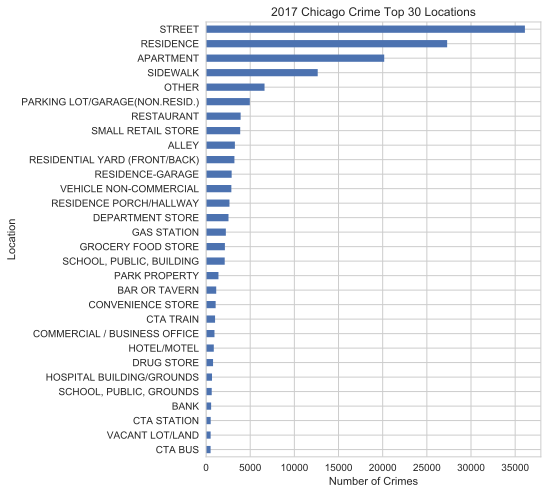

In [17]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True)\
.plot(kind='barh', figsize=(6,8))
plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top 30 Locations')
plt.show()

In [18]:
# get arrests and domestic counts for each location description
crime_location_counts = crimes[['LocationDescription', 'Arrest', 'Domestic']]\
.groupby('LocationDescription').sum().compute()

# add crime location totals column
crime_location_counts['Total'] = crime_locations
crime_location_counts.head()

,Arrest,Domestic,Total
LocationDescription,,,
RESIDENCE,2896.0,9246.0,27299
OTHER,623.0,503.0,6622
"SCHOOL, PUBLIC, BUILDING",523.0,45.0,2113
VEHICLE NON-COMMERCIAL,722.0,393.0,2865
APARTMENT,2958.0,8734.0,20173


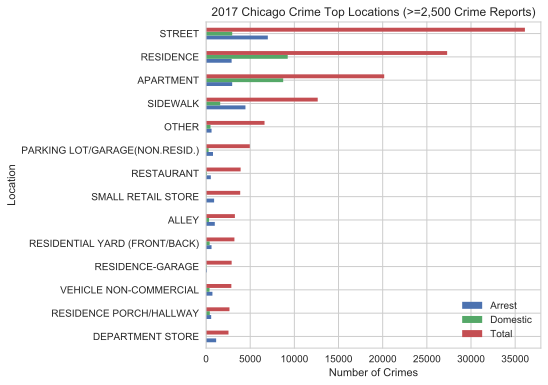

In [19]:
# plot top crime locations with arrests and domestic crime counts
crime_location_counts[crime_location_counts['Total'] >= 2500]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top Locations (>=2,500 Crime Reports)')
plt.show()

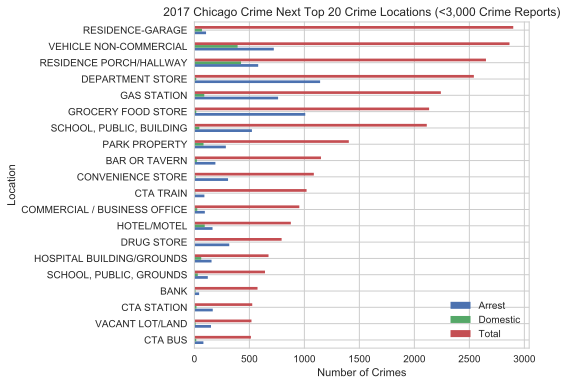

In [20]:
# plot next 20 top crime locations
crime_location_counts = crime_location_counts[crime_location_counts['Total'] <= 3000]\
.sort_values(by='Total', ascending=False)
crime_location_counts[:20].sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Next Top 20 Crime Locations (<3,000 Crime Reports)')
plt.show()

In [21]:
# check for datetime64 index to plot crime over time
crimes.index

Dask Index Structure:
npartitions=1
2017-01-01 00:00:00    datetime64[ns]
2017-08-10 23:55:00               ...
Name: Date, dtype: datetime64[ns]
Dask Name: read-parquet, 2 tasks

In [22]:
# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

Date
2017-01-01 00:00:00    True
2017-01-01 00:00:00    True
2017-01-01 00:00:00    True
2017-01-01 00:01:00    True
2017-01-01 00:05:00    True
Name: Arrest, dtype: bool
...
Total Arrests: 30,819


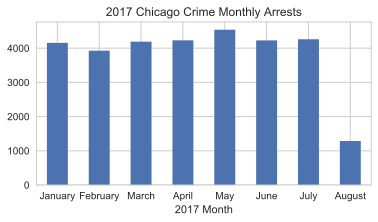

In [23]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(kind='bar', figsize=(6,3))
plt.xticks([0,1,2,3,4,5,6,7], calendar.month_name[1:13], rotation=0)
plt.xlabel('2017 Month')
plt.title('2017 Chicago Crime Monthly Arrests')
plt.show()

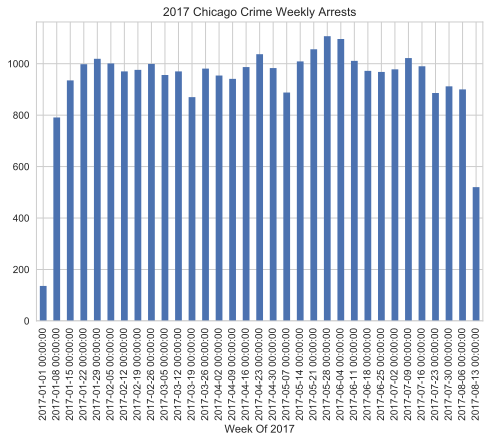

In [24]:
# plot weekly arrests
weekly_arrests = arrests.resample('W').sum().compute()
weekly_arrests.plot(kind='bar')
# TODO: format weekly xticks to only list week start date
plt.xlabel('Week Of 2017')
plt.title('2017 Chicago Crime Weekly Arrests')
plt.show()

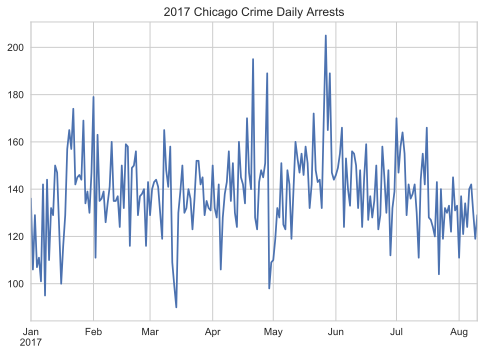

In [25]:
# plot daily arrests
daily_arrests = arrests.resample('D').sum().compute()
daily_arrests.plot()
plt.title('2017 Chicago Crime Daily Arrests')
plt.show()

In [26]:
# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))

Date
2017-01-01    True
2017-01-01    True
2017-01-01    True
2017-01-01    True
2017-01-01    True
Name: Domestic, dtype: bool
...
Total Domestic: 26,261


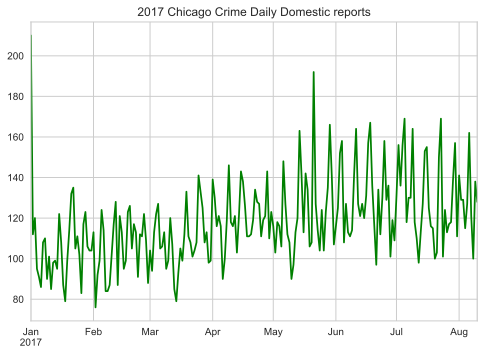

In [27]:
# plot daily domestic crimes
daily_domestic = domestic.resample('D').sum().compute()
daily_domestic.plot(color='g')
plt.title('2017 Chicago Crime Daily Domestic reports')
plt.show()

In [28]:
# get daily total crime counts
daily_crime = crime_types.resample('D').count().compute()

#print daily total crime stats
print(daily_crime.head())
print("...\nTotal Days: {:,}".format(daily_crime.size))

            PrimaryType
2017-01-01          933
2017-01-02          601
2017-01-03          704
2017-01-04          610
2017-01-05          601
...
Total Days: 222


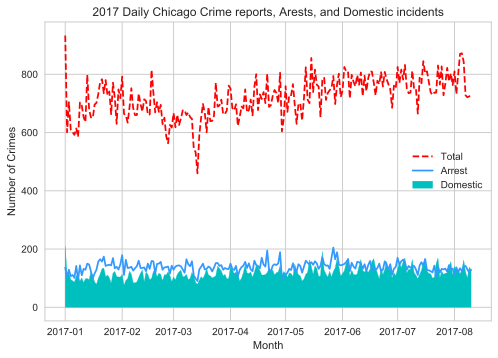

In [29]:
# plot daily crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots()
ax.plot(daily_crime.index, daily_crime, '--', label='Total', color='r', zorder=10)
ax.plot(daily_arrests.index, daily_arrests, color='#3399ff', zorder=10)
ax.fill_between(daily_domestic.index, daily_domestic, label='Domestic', color='c')
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Month')
ax.legend(loc='right')
plt.title('2017 Daily Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

In [30]:
# get select human endangerment crimes
violent_crimes = crime_types[(crime_types['PrimaryType']=='CRIM SEXUAL ASSAULT') | \
                             (crime_types['PrimaryType']=='HOMICIDE') | \
                             (crime_types['PrimaryType']=='HUMAN TRAFFICKING') | \
                             (crime_types['PrimaryType']=='KIDNAPPING') | \
                             (crime_types['PrimaryType']=='OFFENSE INVOLVING CHILDREN')]

# print violent crimes stats
print(violent_crimes.head(10))
print('...............................................')
print(violent_crimes.PrimaryType.value_counts().head(5))

                           PrimaryType
Date                                  
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01         CRIM SEXUAL ASSAULT
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01         CRIM SEXUAL ASSAULT
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
...............................................
OFFENSE INVOLVING CHILDREN    1277
CRIM SEXUAL ASSAULT            907
HOMICIDE                       414
KIDNAPPING                     114
HUMAN TRAFFICKING                6
Name: PrimaryType, dtype: int64


In [31]:
# categorize by primary type
violent_crimes = violent_crimes.categorize(columns='PrimaryType')
print(violent_crimes)

# print selected violent crimes primary type categories
print('\nSelected Primary Type categories:')
print('----------------------------------------------------------------------')
print(violent_crimes.PrimaryType.cat.categories)

Dask DataFrame Structure:
                         PrimaryType
npartitions=1                       
2017-01-01 00:00:00  category[known]
2017-08-10 23:55:00              ...
Dask Name: _categorize_block, 14 tasks

Selected Primary Type categories:
----------------------------------------------------------------------
Index(['OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'CRIM SEXUAL ASSAULT', 'THEFT', 'OTHER OFFENSE', 'SEX OFFENSE',
       'CRIMINAL DAMAGE', 'OBSCENITY', 'BATTERY', 'ASSAULT',
       'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'WEAPONS VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER',
       'PUBLIC PEACE VIOLATION', 'BURGLARY', 'NARCOTICS', 'HOMICIDE',
       'KIDNAPPING', 'ARSON', 'STALKING', 'INTIMIDATION',
       'CONCEALED CARRY LICENSE VIOLATION', 'PROSTITUTION', 'NON-CRIMINAL',
       'LIQUOR LAW VIOLATION', 'PUBLIC INDECENCY', 'GAMBLING',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'HUMAN TRAFFICKING',
       'OTHER NARCOTIC VIOLATION'

In [32]:
# group violent crimes by month and crime type
violent_crimes_groupby = violent_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
violent_crime_data = violent_crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(violent_crime_data.head(10))
print('...')

# unstack violent crime type group for series plotting
violent_crime_data = violent_crime_data.unstack()
print(violent_crime_data.head(12))

print("...\nTotal Monthly/Type records: {:,}".format(violent_crime_data.size))

Date        PrimaryType               
2017-01-31  OFFENSE INVOLVING CHILDREN    217
            CRIM SEXUAL ASSAULT           135
            HOMICIDE                       53
            KIDNAPPING                      8
2017-02-28  OFFENSE INVOLVING CHILDREN    119
            CRIM SEXUAL ASSAULT           118
            HOMICIDE                       48
            KIDNAPPING                     13
2017-03-31  OFFENSE INVOLVING CHILDREN    175
            CRIM SEXUAL ASSAULT            95
Name: Count, dtype: int64
...
PrimaryType  OFFENSE INVOLVING CHILDREN  CRIM SEXUAL ASSAULT  HOMICIDE  \
Date                                                                     
2017-01-31                        217.0                135.0      53.0   
2017-02-28                        119.0                118.0      48.0   
2017-03-31                        175.0                 95.0      37.0   
2017-04-30                        172.0                131.0      46.0   
2017-05-31                 

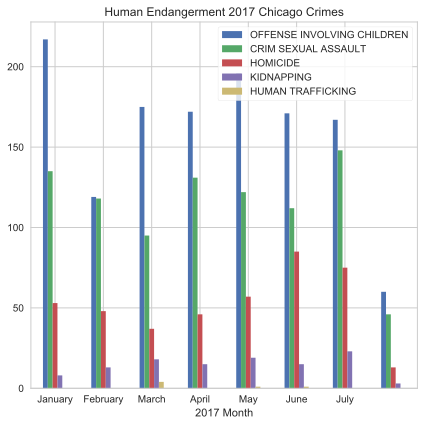

In [33]:
# plot violent crime data
violent_crime_data.plot(figsize=(6,6), kind='bar')
plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Human Endangerment 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [34]:
# get top 5 crimes
top_5_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                             (crime_types['PrimaryType']=='BATTERY') | \
                             (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                             (crime_types['PrimaryType']=='ASSAULT') | \
                             (crime_types['PrimaryType']=='OTHER OFFENSE')]
top_5_crimes.head(10)

,PrimaryType
Date,
2017-01-01,THEFT
2017-01-01,OTHER OFFENSE
2017-01-01,CRIMINAL DAMAGE
2017-01-01,OTHER OFFENSE
2017-01-01,CRIMINAL DAMAGE
2017-01-01,CRIMINAL DAMAGE
2017-01-01,BATTERY
2017-01-01,THEFT
2017-01-01,THEFT


In [35]:
# print top 5 crime counts
top_5_crimes.PrimaryType.value_counts().head()

THEFT              37563
BATTERY            30170
CRIMINAL DAMAGE    17806
ASSAULT            11855
OTHER OFFENSE      10923
Name: PrimaryType, dtype: int64

In [36]:
print('Monthly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by month and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))

Monthly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-31  THEFT              4925
            OTHER OFFENSE      1552
            CRIMINAL DAMAGE    2407
            BATTERY            3557
            ASSAULT            1373
2017-02-28  THEFT              4373
            OTHER OFFENSE      1372
            CRIMINAL DAMAGE    2044
            BATTERY            3407
            ASSAULT            1294
Name: Count, dtype: int64
...
PrimaryType  THEFT  OTHER OFFENSE  CRIMINAL DAMAGE  BATTERY  ASSAULT
Date                                                                
2017-01-31    4925           1552             2407     3557     1373
2017-02-28    4373           1372             2044     3407     1294
2017-03-31    4467           1508             2231     3851     1481
2017-04-30    4752           1549             2439     4095     1635
2017-05-31    5292           1607             2507     4552     1843
201

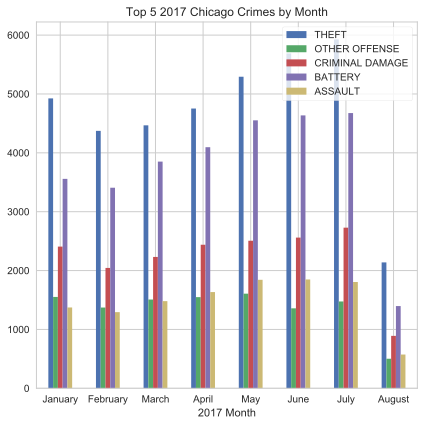

In [37]:
# plot top 5 crimes data
top_5_crime_data.plot(figsize=(6,6), kind='bar')

plt.xticks([0,1,2,3,4,5,6,7], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Top 5 2017 Chicago Crimes by Month')
plt.tight_layout()
plt.show()

In [38]:
print('Weekly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by week and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('W'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Weekly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  THEFT              177
            OTHER OFFENSE       72
            CRIMINAL DAMAGE    113
            BATTERY            202
            ASSAULT             45
2017-01-08  THEFT              909
            OTHER OFFENSE      336
            CRIMINAL DAMAGE    477
            BATTERY            714
            ASSAULT            300
Name: Count, dtype: int64
...
PrimaryType  THEFT  OTHER OFFENSE  CRIMINAL DAMAGE  BATTERY  ASSAULT
Date                                                                
2017-01-01     177             72              113      202       45
2017-01-08     909            336              477      714      300
2017-01-15    1075            383              524      766      292
2017-01-22    1234            349              568      815      338
2017-01-29    1198            319              569      824      312
2017-02-05    

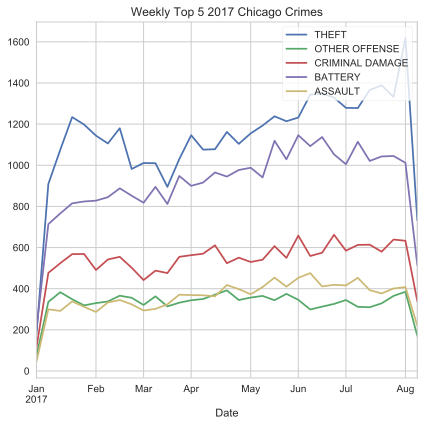

In [39]:
# add weekly arrests data for comparison of crime fighting efforts
#top_5_crime_data['Arrests'] = weekly_arrests

# plot Weekly top 5 crimes data
top_5_crime_data.plot(figsize=(6,6))
plt.legend(loc='upper right', frameon=True)
plt.title('Weekly Top 5 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [40]:
print('Daily Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by day and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('D'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Daily Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  THEFT              177
            OTHER OFFENSE       72
            CRIMINAL DAMAGE    113
            BATTERY            202
            ASSAULT             45
2017-01-02  THEFT              120
            OTHER OFFENSE       44
            CRIMINAL DAMAGE     73
            BATTERY            105
            ASSAULT             38
Name: Count, dtype: int64
...
PrimaryType  THEFT  OTHER OFFENSE  CRIMINAL DAMAGE  BATTERY  ASSAULT
Date                                                                
2017-01-01     177             72              113      202       45
2017-01-02     120             44               73      105       38
2017-01-03     149             43               79      114       55
2017-01-04     161             54               57       95       34
2017-01-05     132             56               68       84       42
2017-01-06     

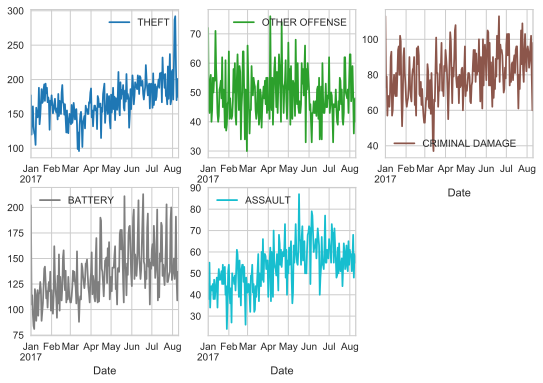

In [41]:
# add daily arrests data for comparison of crime fighting efforts
#top_5_crime_data['Arrests'] = daily_arrests

# plot top 5 daily crimes grid
top_5_crime_data.plot(figsize=(9, 6), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [42]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

,CommunityArea,CommunityName,Side
0,0,NaN,NaN
1,1,Rogers Park,Far North Side
2,2,West Ridge,Far North Side
3,3,Uptown,Far North Side
4,4,Lincoln Square,Far North Side


In [43]:
# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName       Side  Total
25             25           Austin  West Side   9373
8               8  Near North Side    Central   6861
32             32             Loop    Central   6172
28             28   Near West Side  West Side   5392
29             29   North Lawndale  West Side   5284
...
Total Communities: 77


C:\tools\dev\python\Anaconda3\lib\site-packages\pandas\core\indexes\category.py:138: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


In [44]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,9373
Near North Side,6861
Loop,6172
Near West Side,5392
North Lawndale,5284


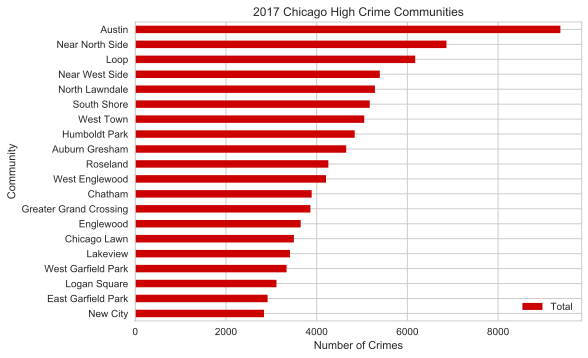

In [45]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh', color='#cc0000')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago High Crime Communities')
plt.show()

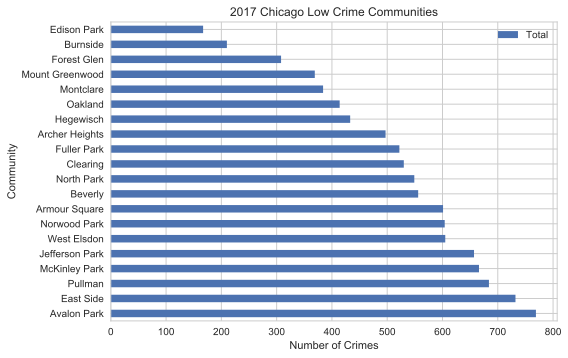

In [46]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False).plot(kind='barh')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Low Crime Communities')
plt.show()

In [47]:
community_areas.head()

,CommunityArea,CommunityName,Side,Total
0,0,NaN,NaN,1
1,1,Rogers Park,Far North Side,2443
2,2,West Ridge,Far North Side,2094
3,3,Uptown,Far North Side,2039
4,4,Lincoln Square,Far North Side,1097


In [48]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum().drop('CommunityArea', axis=1) # denotes column
crime_by_side

,Total
Side,
Central,14175
Far North Side,13891
Far Southeast Side,18755
Far Southwest Side,10243
North Side,11287
Northwest Side,8724
South Side,20874
Southwest Side,21450
West Side,40519


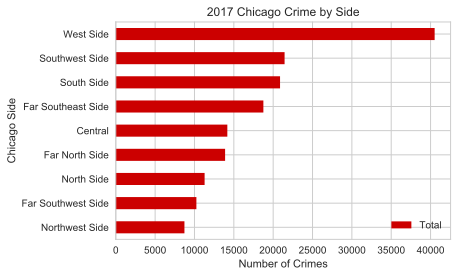

In [49]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4), color='#cc0000')
plt.ylabel('Chicago Side')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime by Side')
plt.show()

In [50]:
# show Chicago sides svg for reference
display(SVG(url='../data/chicago-community-areas.svg'))

<IPython.core.display.SVG object>